# This is a notebook to solve the Kaggle Titanic challenge.
The goal is to predict the survival of passengers. The final model uses ensemble methods put together for vote. Accuracy on the training/validation sets in the range [0.81-0.84]. Score on the test set around 0.80. Different age/fare groups and family attributes were tested but no big difference overall.


# Setup and definition of some functions

In [1]:
# Common imports

import numpy as np
import os
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer


# To plot pretty figures

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


# General variables and options

DATA_PATH = './titanic/'


# Functions

def load_this_data(this_path, this_filename):
    
    """ Function to read the dataset
    
        Input: path and filename
        Output: Panda Dataframe
    """
    
    csv_path = os.path.join(this_path, this_filename)
    
    return pd.read_csv(csv_path)


def feature_pipeline(this_dataset):
    
    """ Function to run automatically and in the right order
        through the imputing and feature creating functions below
    
        Input: Panda DataFrame
        Output: Panda DataFrame
    """

    pip_impute_fare(this_dataset)
    pip_extract_title(this_dataset)
    pip_extract_titlecat(this_dataset)
    pip_extract_familycat(this_dataset)
    pip_extract_relatives(this_dataset)
    pip_extract_faregroup(this_dataset)
    pip_extract_agegroup(this_dataset)
    pip_extract_hascabin(this_dataset)
    pip_impute_embark(this_dataset)
    pip_categorize(this_dataset)
    
    
# Imputing and extracting features
def pip_impute_fare(this_dataset):
    
    """ Replaces missing values with mean from Pclass"""

    tmp_fare = this_dataset["Fare"].map(lambda s: s if (s >= 0) else -1)
    for this_class in [1,2,3]:
        mean_fare = original_set.Fare[((original_set.Pclass == this_class) & (original_set.Fare > 0))].mean()
        tmp_fare[((tmp_fare == -1) & (this_dataset.Pclass == this_class))] = mean_fare
    this_dataset["Fare"] = tmp_fare
    
    
def pip_extract_title(this_dataset):
    
    """ Create feature based on title in name """

    set_title = [i.split(",")[1].split(".")[0].strip() for i in this_dataset["Name"]]
    this_dataset["Title"] = pd.Series(set_title)

    
def pip_extract_titlecat(this_dataset):
    
    """ Create categorical feature based on title """

    is_fancy = ['the Countess','Countess','Lady','Sir']
    is_rare = ['Rev','Capt','Dr','Major','Col','Jonkheer','Don','Dona']
    this_dataset['is_mr'] = this_dataset['Title'].map(lambda s: 1 if (s=='Mr') else 0)
    this_dataset['is_mrs'] = this_dataset['Title'].map(lambda s: 1 if ((s=='Mrs') or (s=='Mme')) else 0)
    this_dataset['is_miss'] = this_dataset['Title'].map(lambda s: 1 if ((s=='Miss') or (s=='Mlle') or (s=='Ms')) else 0)
    this_dataset['is_master'] = this_dataset['Title'].map(lambda s: 1 if (s=='Master') else 0)
    this_dataset['is_fancy'] = this_dataset['Title'].map(lambda s: 1 if (s in is_fancy) else 0)
    this_dataset['is_rare'] = this_dataset['Title'].map(lambda s: 1 if (s in is_rare) else 0)
    
    
def pip_extract_familycat(this_dataset):
    
    """ Create categorical feature based on family size """

    tmp_small_family = this_dataset['Parch'].map(lambda s: 1 if (s == 1 or s == 2) else 0)
    tmp_small_family[(this_dataset.SibSp > 2)] = 0
    this_dataset['fam_small'] = tmp_small_family

    tmp_big_family = this_dataset['Parch'].map(lambda s: 1 if (s > 2) else 0)
    tmp_big_family[((this_dataset.SibSp > 2) & (this_dataset.Parch > 0))] = 1
    this_dataset['fam_big'] = tmp_big_family

    
def pip_extract_relatives(this_dataset):
    
    """ Create categorical feature based on presence of a relative """

    this_dataset["relatives_on"] = this_dataset["SibSp"] + this_dataset["Parch"]
    

def pip_extract_faregroup(this_dataset):
    
    """ Create feature based on fare range """

    bins = [0, 10, 50] #most expensive have 0 for all groups
    this_dataset["fare_group1"] = this_dataset['Fare'].map(lambda s: 1 if ((s >= bins[0]) and (s < bins[1])) else 0)
    this_dataset["fare_group2"] = this_dataset['Fare'].map(lambda s: 1 if ((s >= bins[1]) and (s < bins[2])) else 0)


def pip_extract_agegroup(this_dataset):
    
    """ Create feature based on age range, impute age on title category """

    tmp_age = this_dataset["Age"].map(lambda s: s if not pd.isnull(s) else -1)
    for this_title in ['is_rare','is_fancy','is_master','is_miss','is_mrs','is_mr']:
        median_age = original_set.Age[((original_set[this_title] == 1) & (tmp_age > 0))].median()
        tmp_age[((tmp_age == -1) & (this_dataset[this_title] == 1))] = median_age
    bins = [0, 5, 18, 60] #oldest have 0 for all groups
    this_dataset["age_group1"] = tmp_age.map(lambda s: 1 if ((s >= bins[0]) and (s < bins[1])) else 0)
    this_dataset["age_group2"] = tmp_age.map(lambda s: 1 if ((s >= bins[1]) and (s < bins[2])) else 0)
    this_dataset["age_group3"] = tmp_age.map(lambda s: 1 if ((s >= bins[2]) and (s < bins[3])) else 0)


def pip_extract_hascabin(this_dataset):
    
    """ Create feature based on owning a cabin """

    this_dataset['has_cabin'] = this_dataset['Cabin'].map(lambda s: 1 if not pd.isnull(s) else 0)
    

def pip_impute_embark(this_dataset):
    
    """ Impute Embark based on most frequent """

    this_dataset['Embarked'] = this_dataset['Embarked'].replace(np.nan, 'S')

    
def pip_categorize(this_dataset):
    
    # convert Embarked (C,S) into (0,1)*2; Q has (0,0)
    this_dataset["port_embark_C"] = this_dataset['Embarked'].map(lambda s: 1 if (s=='C') else 0)
    this_dataset["port_embark_S"] = this_dataset['Embarked'].map(lambda s: 1 if (s=='S') else 0)

    # convert sex into 0:male, 1:female
    sex_mapping = {"male": 0, "female": 1}
    this_dataset['is_female'] = this_dataset['Sex'].map(sex_mapping)
    
    #convert passenger class too (0,1)*2; class3 has (0,0)
    this_dataset["class_1"] = this_dataset['Pclass'].map(lambda s: 1 if (s==1) else 0)
    this_dataset["class_2"] = this_dataset['Pclass'].map(lambda s: 1 if (s==2) else 0)


# Part 1: explore the training data set.
There are 891 passengers, 1 response and 10 features in the training set. 
- survived: 0 or 1. 342 passengers survived.
- Pclass: integer 1 or 2 or 3; mean 2.309, stdev 0.836.
- Name: string object, could sort out families and loop on outcome of family members (not implemented here)
- sex: string male/female
- age: float between 0.42 and 80; mean 29.699, stdev 14.526. 
    714 entries -> 177 entries missing
- SibSp: integer 0 to 8. mean 0.523, stdev 1.103. = sibling/spouse
- Parch: integer 0 to 6. mean 0.382, stdev 0.806. = parent/child
- Ticket: string object (letters and numbers)
- Fare: float between 0 and 512.329. mean 32.204, stdev 49.693.
- Cabin: object. 
    204 entries only.
- Embarked: string object (C = Cherbourg, Q = Queenstown, S = Southampton). 
    889 entries -> 2 entries missing


In [2]:
# Load the training data and print out general information

original_set = load_this_data(DATA_PATH,"train.csv")
original_set_save = original_set.copy()

print(original_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


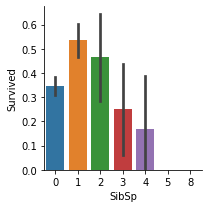

In [3]:
# siblings/spouse
sns.catplot(x="SibSp",y="Survived",data=original_set,kind="bar",height=3)

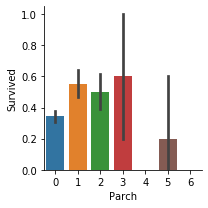

In [4]:
# parent/child
sns.catplot(x="Parch",y="Survived",data=original_set,kind="bar",height=3)

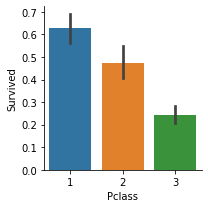

In [5]:
# passenger class
sns.catplot(x="Pclass",y="Survived",data=original_set,kind="bar",height=3)

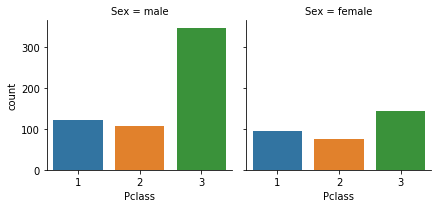

In [6]:
# passenger class and sex
sns.catplot("Pclass", col="Sex",data=original_set,kind="count",height=3)

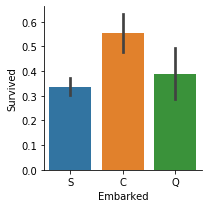

In [7]:
# embarkation port
sns.catplot(x="Embarked",y="Survived",data=original_set,kind="bar",height=3)

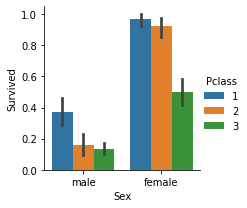

In [8]:
# passenger sex
sns.catplot(x="Sex",y="Survived",hue='Pclass',data=original_set,kind="bar",height=3)

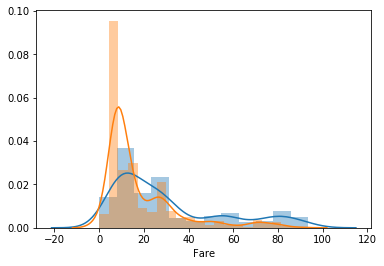

In [9]:
# fare filling missing values
pip_impute_fare(original_set)    

# fare distribution
fare_survived = original_set.Fare[(original_set.Survived == 1) & (original_set.Fare <100)]
sns.distplot(fare_survived.dropna())

fare_notsurvived = original_set.Fare[(original_set.Survived == 0) & (original_set.Fare <100)]
sns.distplot(fare_notsurvived.dropna())

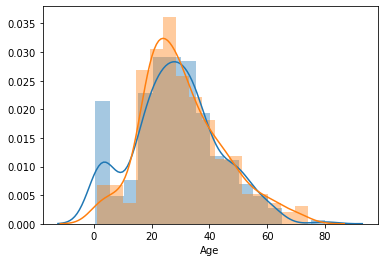

In [10]:
# we will impute age based on title (see below)

# age distributions
age_survived = original_set.Age[original_set.Survived == 1]
sns.distplot(age_survived.dropna())

age_notsurvived = original_set.Age[original_set.Survived == 0]
sns.distplot(age_notsurvived.dropna())

# explore new features

- title in name

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Jonkheer          1
Ms                1
Sir               1
Capt              1
Mme               1
Lady              1
the Countess      1
Don               1
Name: Title, dtype: int64

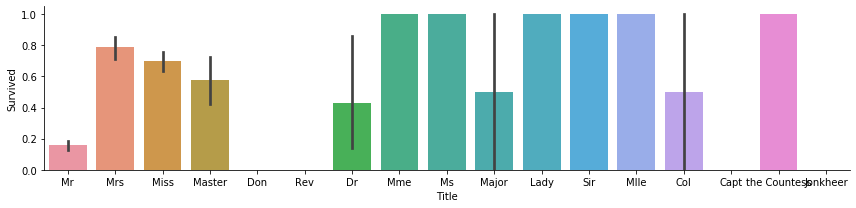

In [11]:
# Get title from name
pip_extract_title(original_set)

#plot
sns.catplot(x="Title",y="Survived",data=original_set,kind="bar",height=3,aspect=4)
original_set["Title"].value_counts()

In [12]:
# Convert title to categorical values 
pip_extract_titlecat(original_set)

- family size

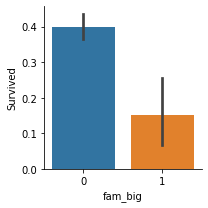

In [13]:
# is a big, smallish family, or not a family
pip_extract_familycat(original_set)

#plot
#sns.catplot(x="fam_small",y="Survived",data=original_set,kind="bar",height=3)
sns.catplot(x="fam_big",y="Survived",data=original_set,kind="bar",height=3)

- relatives onboard

In [14]:
pip_extract_relatives(original_set)

- fare group

In [15]:
#make 2 groups: cheap (1,0), moderate (0,1), expensive (0,0)
pip_extract_faregroup(original_set)

- age group

In [16]:
#make 3 groups: baby, child, adult; eldest will be 0
# age imputed based on title
pip_extract_agegroup(original_set)

- cabin

In [17]:
#many nan entries. has a cabin or not
pip_extract_hascabin(original_set)

# categorize features and scale

In [18]:
#impute embark
pip_impute_embark(original_set)    

#categorize (Embark, Sex, Pclass)
pip_categorize(original_set)

In [19]:
# Separate set into training and validation sets
test_size = 0.25
seed = 0
training_set, validation_set = train_test_split(original_set, \
                                             test_size=test_size, random_state=seed)

In [20]:
# check out correlation coefficients : the sex, fare and class seem important
corr_matrix = training_set.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived         1.000000
is_female        0.548061
is_mrs           0.359825
is_miss          0.328163
has_cabin        0.299929
class_1          0.265194
fam_small        0.232800
Fare             0.228372
port_embark_C    0.147703
class_2          0.111643
age_group1       0.103243
is_master        0.088741
is_fancy         0.084670
Parch            0.081584
age_group2       0.074286
fare_group2      0.055076
relatives_on     0.005342
PassengerId     -0.011614
is_rare         -0.039365
SibSp           -0.050014
Age             -0.083146
age_group3      -0.093069
fam_big         -0.106445
port_embark_S   -0.132781
fare_group1     -0.261434
Pclass          -0.326264
is_mr           -0.563678
Name: Survived, dtype: float64

In [21]:
# drop originals of some extracted features

list_features_drop = ["Age","Title","Name","Ticket","Cabin","Fare",\
                      "Embarked","Pclass","Sex"]
                    #  "fam_small","fam_big","relatives_on"]
                    #  "Parch","SibSp",\
                    #  "age_group","fare_group",\
                    #  "has_cabin"]

training_set = training_set.drop(labels=list_features_drop,axis=1)
validation_set = validation_set.drop(labels=list_features_drop,axis=1)

print(training_set.shape)

(668, 24)


In [22]:
# Extract dataset

X_data = training_set.drop(["Survived","PassengerId"],axis=1)
feature_list = X_data.columns

X_data_val = validation_set.drop(["Survived","PassengerId"],axis=1)

y_data = training_set["Survived"]
y_data_val = validation_set["Survived"]

print(X_data.shape,y_data.shape)

(668, 22) (668,)


In [23]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 105 to 684
Data columns (total 22 columns):
SibSp            668 non-null int64
Parch            668 non-null int64
is_mr            668 non-null int64
is_mrs           668 non-null int64
is_miss          668 non-null int64
is_master        668 non-null int64
is_fancy         668 non-null int64
is_rare          668 non-null int64
fam_small        668 non-null int64
fam_big          668 non-null int64
relatives_on     668 non-null int64
fare_group1      668 non-null int64
fare_group2      668 non-null int64
age_group1       668 non-null int64
age_group2       668 non-null int64
age_group3       668 non-null int64
has_cabin        668 non-null int64
port_embark_C    668 non-null int64
port_embark_S    668 non-null int64
is_female        668 non-null int64
class_1          668 non-null int64
class_2          668 non-null int64
dtypes: int64(22)
memory usage: 120.0 KB


In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_data)
X_val = scaler.transform(X_data_val)

y_train = y_data
y_val = y_data_val

# train several models

In [25]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, \
    VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier


kfold = StratifiedKFold(n_splits=10)

log_reg = LogisticRegression(solver="liblinear", random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
adab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=1, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

estimators = [log_reg, svm_clf, rnd_clf, extra_clf, adab_clf, gb_clf, xgb_clf]
estimators_list = [ "LogisticRegression",\
                    "SVC",\
                    "RandomForestClassifier",\
                    "ExtraTreesClassifier",\
                    "AdaBoostClassifier",\
                    "GradientBoosting",\
                    "XGBoost"]

y_train_scores_mean = []
y_train_scores_std = []

for estimator in estimators:
    this_scores = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring="accuracy")
    estimator.fit(X_train, y_train)
    y_train_scores_mean.append(this_scores.mean())
    y_train_scores_std.append(this_scores.std())

In [26]:
y_train_scores_mean

[0.830958842152872,
 0.8279511533242877,
 0.7904115784712801,
 0.7948439620081411,
 0.8159203980099502,
 0.8143374038896427,
 0.8249208502939845]

Text(0.5, 0, 'Average cv score')

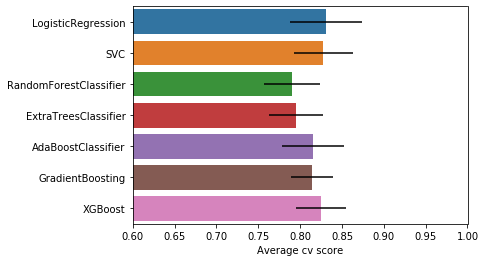

In [27]:
p1 = sns.barplot(x=y_train_scores_mean,y=estimators_list,orient = "h",**{'xerr':y_train_scores_std})
p1.set(xlim=(.6,1))
p1.set_xlabel("Average cv score")

In [28]:
def plot_feature_importance(estimator,title):
    feature_importance = estimator.feature_importances_
    isort = (np.argsort(feature_importance))[::-1]
    x_values = feature_importance[isort[0:12]]
    y_values = feature_list[isort[0:12]]
        
    pp = sns.barplot(x=x_values,y=y_values,orient = "h")
    pp.set_xlabel("Importance")
    pp.set_ylabel("Feature")
    pp.set_title(title)

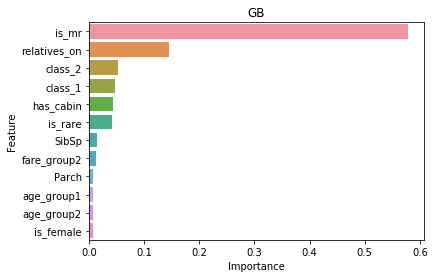

In [29]:
plot_feature_importance(gb_clf,"GB")

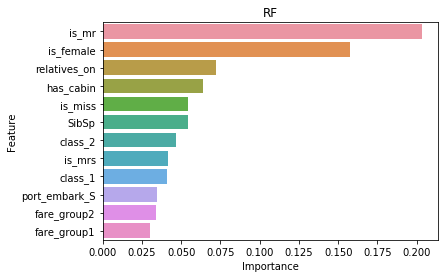

In [30]:
plot_feature_importance(rnd_clf,"RF")

# fine-tune the best ones 
(GradientBoosting, RandomForest, AdaBoostClassifier, LogisticRegression, SVC for check)

In [31]:
final_best_scores = []
final_clf_list = ["GradientBoostingClassifier","RandomForestClassifier",\
                  "AdaBoostClassifier","LogisticRegression","SVC","XGBoost"]

In [32]:
# Gradient boosting tuning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV 

gb_clf = GradientBoostingClassifier(random_state=42)
gb_param_grid = {'loss' : ["deviance"],
                 'n_estimators' : [10,20,30],
                 'learning_rate': [0.01,0.03,0.1],
                 'max_depth': [2,3,4],
                 'min_samples_leaf': [0.03,0.1],
                 'max_features': [0.1, 0.3, 0.5] 
                }

gb_search = GridSearchCV(gb_clf, param_grid=gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
gb_search.fit(X_train,y_train)

gb_clf_best = gb_search.best_estimator_
save_results_gb = gb_search.cv_results_

# Best score
final_best_scores.append(gb_search.best_score_)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:   12.5s finished


In [33]:
gb_search.best_score_, gb_clf_best

(0.8323353293413174,
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=0.3, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=0.03, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=20,
                            n_iter_no_change=None, presort='auto',
                            random_state=42, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False))

- check overfitting on validation set with early stopping

15


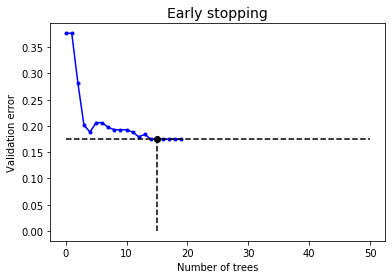

In [34]:
from sklearn.metrics import mean_squared_error

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gb_clf_best.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1
min_error = np.min(errors)

print(bst_n_estimators)

plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 50], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.xlabel("Number of trees")
plt.ylabel("Validation error")
plt.title("Early stopping", fontsize=14)
plt.show()

- plot learning curves

In [35]:
def plot_learning_curves(model, Xt, yt, Xv, yv):
    train_errors, val_errors = [], []
    for m in range(10, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    print(np.sqrt(train_errors[-1]),np.sqrt(val_errors[-1]))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.show() 

0.40610040781730977 0.41819599756176723


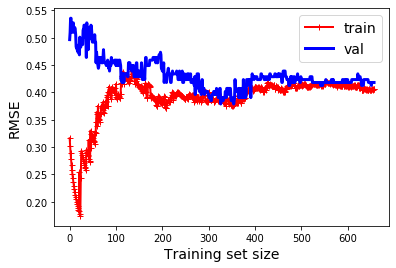

In [36]:
plot_learning_curves(gb_clf_best, X_train, y_train, X_val, y_val)

In [37]:
# Random Forest tuning

rnd_clf = RandomForestClassifier(random_state=42)
rnd_param_grid = {"n_estimators" :[10,20,30],
                  "max_depth": [3,4,5],
                  "min_samples_leaf": [0.03, 0.1],
                  "max_features": [0.1, 0.3, 0.5]
                 }

rnd_search = GridSearchCV(rnd_clf, param_grid=rnd_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
rnd_search.fit(X_train,y_train)

rnd_clf_best = rnd_search.best_estimator_
save_results_rnd = rnd_search.cv_results_

# Best score
final_best_scores.append(rnd_search.best_score_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    3.8s finished
/Users/dcormier/anaconda3/envs/dswork/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
rnd_search.best_score_, rnd_clf_best

(0.8308383233532934,
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=3, max_features=0.5, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=0.03, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False))

0.40794214247145133 0.41279969409381373


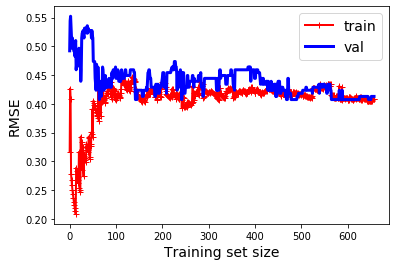

In [39]:
plot_learning_curves(rnd_clf_best, X_train, y_train, X_val, y_val)

In [40]:
# AdaBoost tuning

adab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42)

adab_param_grid = {"base_estimator__min_samples_leaf": [0.03, 0.1],
                   "base_estimator__max_features": [0.1, 0.3, 0.5],
                   "n_estimators" :[20,40,60],
                   "learning_rate":  [0.03,0.1,0.3]
                  }

adab_search = GridSearchCV(adab_clf, param_grid=adab_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
adab_search.fit(X_train,y_train)

adab_clf_best = adab_search.best_estimator_
save_results_adab = adab_search.cv_results_

# Best score
final_best_scores.append(adab_search.best_score_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    9.5s finished


In [41]:
adab_search.best_score_, adab_clf_best

(0.8323353293413174, AdaBoostClassifier(algorithm='SAMME.R',
                    base_estimator=DecisionTreeClassifier(class_weight=None,
                                                          criterion='gini',
                                                          max_depth=1,
                                                          max_features=0.1,
                                                          max_leaf_nodes=None,
                                                          min_impurity_decrease=0.0,
                                                          min_impurity_split=None,
                                                          min_samples_leaf=0.03,
                                                          min_samples_split=2,
                                                          min_weight_fraction_leaf=0.0,
                                                          presort=False,
                                                          random_state=

0.40794214247145133 0.41819599756176723


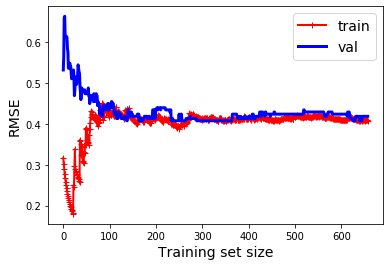

In [42]:
plot_learning_curves(adab_clf_best, X_train, y_train, X_val, y_val)

In [43]:
# Logistic Regression tuning

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_param_grid = {'C': [0.01,0.1,1,10,100,1e3],
                  'penalty':["l1","l2"],
                  'solver': ["liblinear","saga"]}

log_search = GridSearchCV(log_reg, param_grid=log_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
log_search.fit(X_train,y_train)

log_reg_best = log_search.best_estimator_
save_results_log = log_search.cv_results_

# Best score
final_best_scores.append(log_search.best_score_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.0s finished


In [44]:
log_search.best_score_, log_reg_best

(0.8323353293413174,
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='warn', n_jobs=None, penalty='l1',
                    random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False))

0.4023916506089063 0.4235235498876267


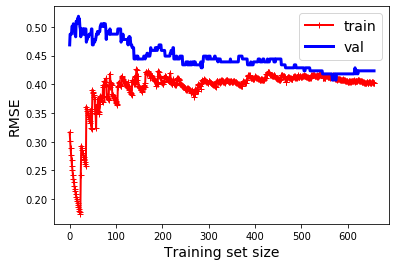

In [45]:
plot_learning_curves(log_reg_best, X_train, y_train, X_val, y_val)

In [46]:
# SVC tuning

svc_clf = SVC(probability=True, random_state=42)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.1, 0.3, 1, 2],
                  'C': [0.01,0.03,0.1],
                  'degree': [2,3,4]
                 }

svc_search = GridSearchCV(svc_clf, param_grid=svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
svc_search.fit(X_train,y_train)

svc_clf_best = svc_search.best_estimator_
save_results_svc = svc_search.cv_results_

# Best score
final_best_scores.append(svc_search.best_score_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    7.8s finished


In [47]:
svc_search.best_score_, svc_clf_best

(0.8278443113772455, SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=2, gamma=1, kernel='rbf', max_iter=-1,
     probability=True, random_state=42, shrinking=True, tol=0.001,
     verbose=False))

0.39864839110441036 0.4287849137296606


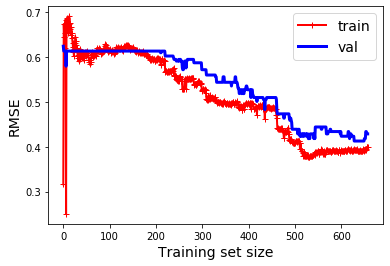

In [48]:
plot_learning_curves(svc_clf_best, X_train, y_train, X_val, y_val)

In [49]:
# XGBoost tuning
from sklearn.model_selection import GridSearchCV 

xgb_clf = XGBClassifier(random_state=42)
xgb_param_grid = {'eta' : [0.03,0.1],
                 'max_depth': [2,3,4],
                 'learning_rate': [0.01,0.1,0.3],
                 'colsample_bytree': [0.1,0.3,0.5],
                 'n_estimators' :[20,40,60]
                }

xgb_search = GridSearchCV(xgb_clf, param_grid=xgb_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
xgb_search.fit(X_train,y_train)

xgb_clf_best = xgb_search.best_estimator_
save_results_xgb = xgb_search.cv_results_

# Best score
final_best_scores.append(xgb_search.best_score_)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:   15.0s finished


In [50]:
xgb_search.best_score_, xgb_clf_best

(0.8353293413173652,
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.3, eta=0.03, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=4,
               min_child_weight=1, missing=None, n_estimators=40, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1))

0.40052439389498806 0.41279969409381373


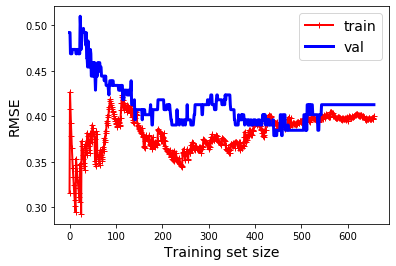

In [51]:
plot_learning_curves(xgb_clf_best, X_train, y_train, X_val, y_val)

# plot feature importance of best estimators

In [52]:
def plot_feature_importance(estimator,title):
    feature_importance = estimator.feature_importances_
    isort = (np.argsort(feature_importance))[::-1]
    x_values = feature_importance[isort[0:12]]
    y_values = feature_list[isort[0:12]]
        
    pp = sns.barplot(x=x_values,y=y_values,orient = "h")
    pp.set_xlabel("Importance")
    pp.set_ylabel("Feature")
    pp.set_title(title)

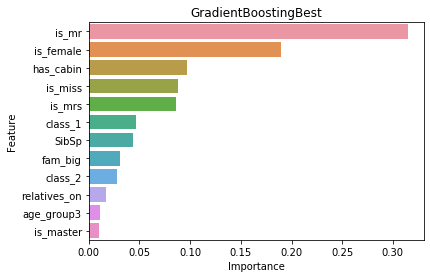

In [53]:
plot_feature_importance(gb_clf_best,"GradientBoostingBest")

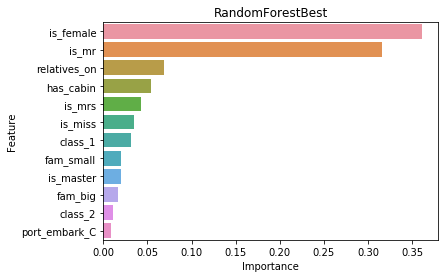

In [54]:
plot_feature_importance(rnd_clf_best,"RandomForestBest")

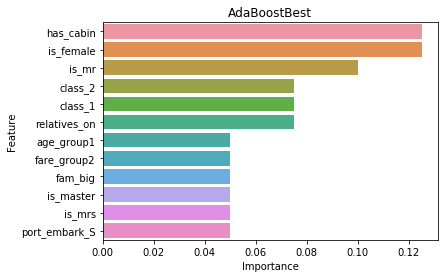

In [55]:
plot_feature_importance(adab_clf_best,"AdaBoostBest")

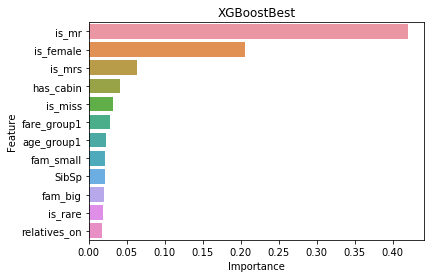

In [56]:
plot_feature_importance(xgb_clf_best,"XGBoostBest")

# put best estimators together for vote

In [57]:
voting_clf = VotingClassifier(
    estimators=[('gb', gb_clf_best), ('rnd', rnd_clf_best), ('adab', adab_clf_best), \
                ('log_reg', log_reg_best), ('svc', svc_clf_best), ('xgb', xgb_clf_best)]) 

voting_clf.fit(X_train, y_train)

voting_clf.voting = "soft"
voting_clf.score(X_train, y_train)

0.8383233532934131

In [58]:
voting_clf.score(X_val, y_val)

0.8340807174887892

In [59]:
#individual performance on validation set
for this_estimator in [gb_clf_best,rnd_clf_best,adab_clf_best,log_reg_best,svc_clf_best,xgb_clf_best]:
    print(this_estimator.score(X_val, y_val))

0.8251121076233184
0.8295964125560538
0.8251121076233184
0.820627802690583
0.8161434977578476
0.8295964125560538


# final part: apply on test set


In [60]:
#Load test_set
test_set = load_this_data(DATA_PATH,"test.csv")

test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [61]:
#process test set
feature_pipeline(test_set)

In [62]:
#drop and transform
test_set = test_set.drop(labels=list_features_drop, axis=1)
X_data_test = test_set.drop(labels=["PassengerId"],axis=1)

X_test = scaler.transform(X_data_test)

X_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 22 columns):
SibSp            418 non-null int64
Parch            418 non-null int64
is_mr            418 non-null int64
is_mrs           418 non-null int64
is_miss          418 non-null int64
is_master        418 non-null int64
is_fancy         418 non-null int64
is_rare          418 non-null int64
fam_small        418 non-null int64
fam_big          418 non-null int64
relatives_on     418 non-null int64
fare_group1      418 non-null int64
fare_group2      418 non-null int64
age_group1       418 non-null int64
age_group2       418 non-null int64
age_group3       418 non-null int64
has_cabin        418 non-null int64
port_embark_C    418 non-null int64
port_embark_S    418 non-null int64
is_female        418 non-null int64
class_1          418 non-null int64
class_2          418 non-null int64
dtypes: int64(22)
memory usage: 72.0 KB


In [63]:
#make predictions and save
voting_clf.voting = "soft"

final_pred = voting_clf.predict(X_test).astype(int)
pass_ids = test_set["PassengerId"]

print(np.sum(final_pred)/len(final_pred))

submission = pd.DataFrame({
        "PassengerId": pass_ids,
        "Survived": final_pred
    })
#submission.to_csv('./submission_pred_new.csv', index=False)

0.39712918660287083
